# Exploratory Data Analysis

In [1]:
%matplotlib inline

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

# Load data 

In [2]:
df = pd.read_csv('../data/hmeq.csv') # load data
print("Data size:", df.shape) # print data size
df.columns = [x.lower() for x in df.columns] # column names in lower case
df.head()

Data size: (5960, 13)


,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


# Data types

The data shows that there are two categorical variables and some variables have missing values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bad      5960 non-null   int64  
 1   loan     5960 non-null   int64  
 2   mortdue  5442 non-null   float64
 3   value    5848 non-null   float64
 4   reason   5708 non-null   object 
 5   job      5681 non-null   object 
 6   yoj      5445 non-null   float64
 7   derog    5252 non-null   float64
 8   delinq   5380 non-null   float64
 9   clage    5652 non-null   float64
 10  ninq     5450 non-null   float64
 11  clno     5738 non-null   float64
 12  debtinc  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


# Percentage of missing values

The variables debtinc and derog have the highest percentage of missing values. Although missing values does not affect exploratory data analysis, we will impute them when doing machine learning

In [4]:
# Compute percentage of missing values
missing_values = (df.isnull().sum()/df.shape[0])*100

# Dataframe of missing values
missing_df =pd.DataFrame({'Variable': missing_values.index, '% missing values': missing_values.values})
missing_df.sort_values(by = '% missing values', ascending = False).reset_index(drop = True)

,Variable,% missing values
0,debtinc,21.258389
1,derog,11.879195
2,delinq,9.731544
3,mortdue,8.691275
4,yoj,8.640940
5,ninq,8.557047
6,clage,5.167785
7,job,4.681208
8,reason,4.228188
9,clno,3.724832


# Categorical variables

In [5]:
df.job.value_counts()

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: job, dtype: int64

In [6]:
df.reason.value_counts()

DebtCon    3928
HomeImp    1780
Name: reason, dtype: int64

# Class distribution

In [7]:
(df.bad.value_counts()/df.shape[0])*100

0    80.050336
1    19.949664
Name: bad, dtype: float64

# Statistical description

In [9]:
df.describe()

,bad,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


# Predictors' Correlation
The correlation matrix shows slightly high correlation between value and mortdue

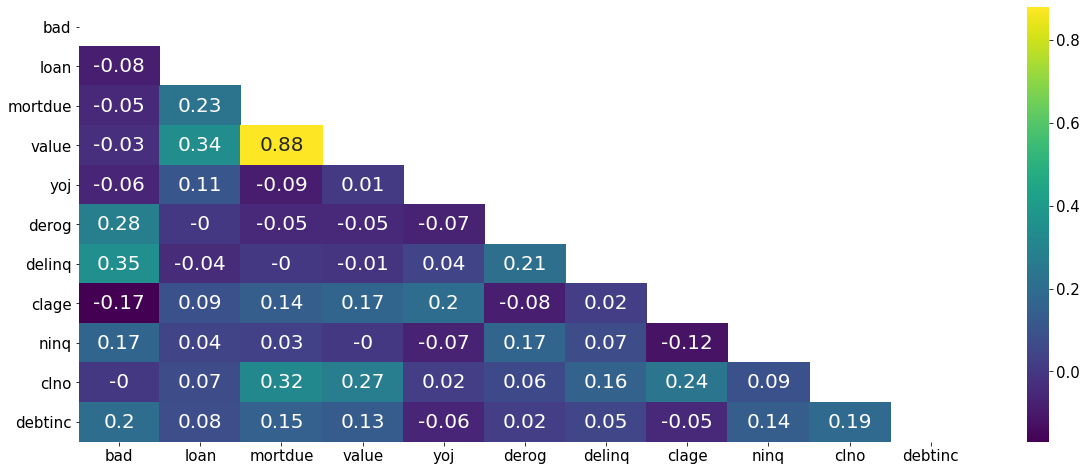

In [10]:
fig, ax = plt.subplots(figsize=(20,8))

# Correlation matrix
corr_matrix = df.corr()

# Plot
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(round(corr_matrix, 2), annot=True, annot_kws={"size": 20},mask = mask, 
            cmap = plt.get_cmap("viridis"),ax = ax)
plt.show()

# Histogram
The histogram distribution shows that the nnumerical variables are right screwed due to outliers. This suggest log(1+x) transformation during modeling

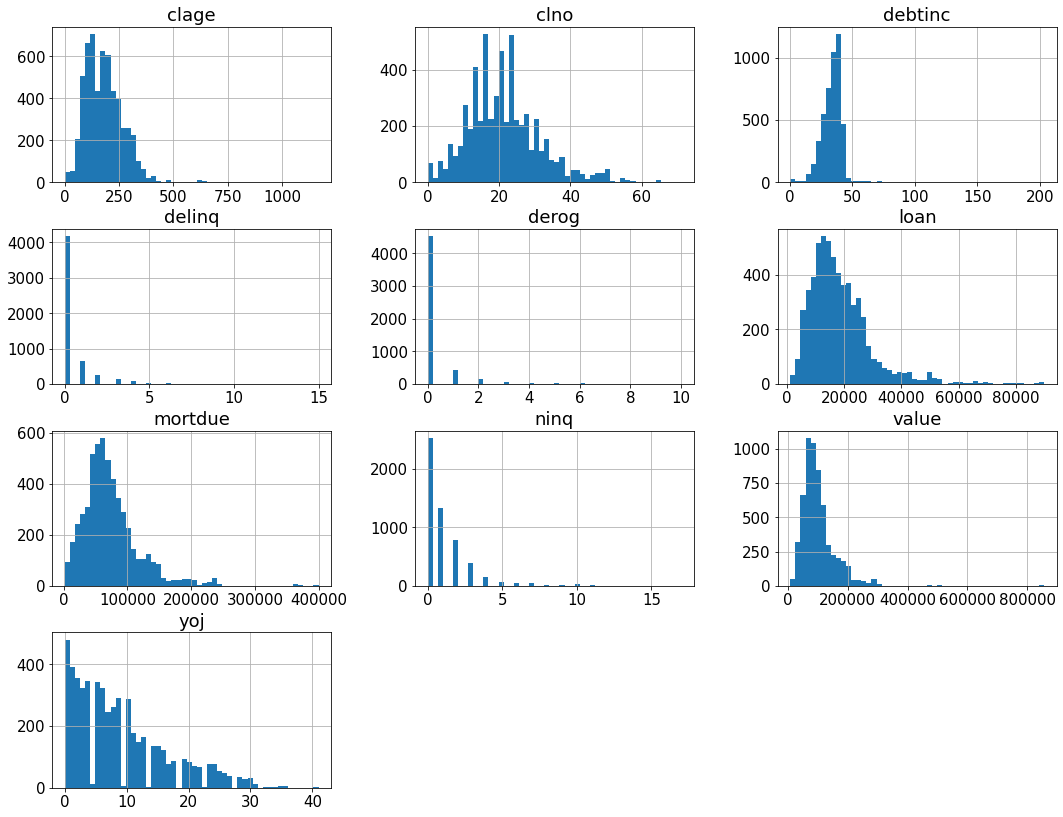

In [11]:
df.drop('bad', axis = 1).hist(bins = 50, figsize = (18,14))
plt.show()

# Default rate by number of credit lines

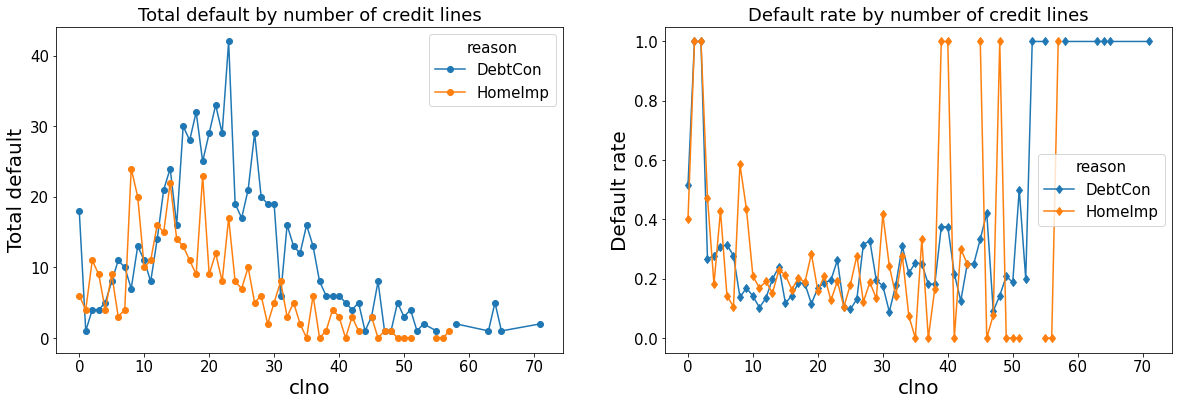

In [20]:
# set figure
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,6))

# pivot table
pivot_tab_1 = df.pivot_table('bad', index = 'clno', columns = 'reason', aggfunc = 'sum')
pivot_tab_2 = df.pivot_table('bad', index = 'clno', columns = 'reason', aggfunc = 'mean')

# plots
pivot_tab_1.plot(marker = 'o', ax = ax1)
pivot_tab_2.plot(marker = 'd', ax = ax2)

ax1.set_xlabel('clno', fontsize = 20)
ax1.set_ylabel('Total default', fontsize = 20)
ax1.set_title('Total default by number of credit lines')
ax2.set_xlabel('clno', fontsize = 20)
ax2.set_ylabel('Default rate', fontsize = 20)
ax2.set_title('Default rate by number of credit lines')
plt.savefig('../images/fig1.png')

# Default rate by number of recent credit inquiries & major derogatory reports

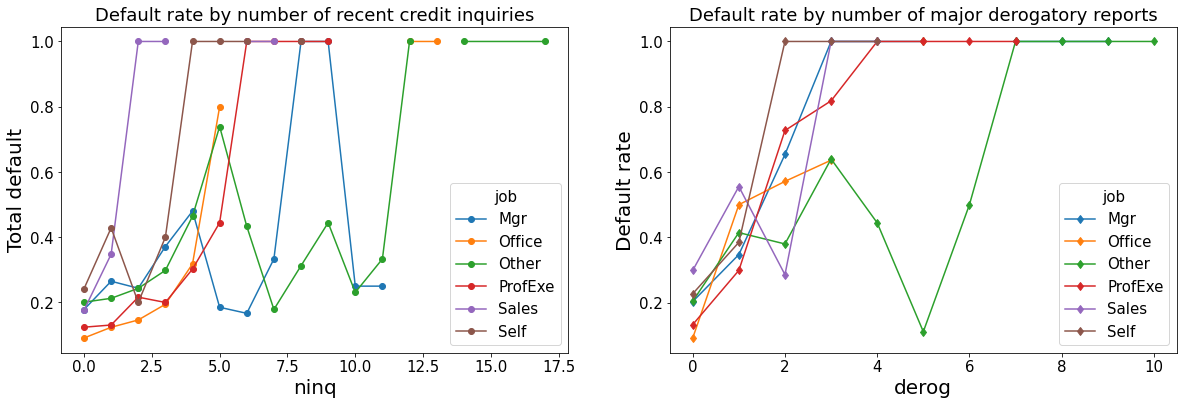

In [32]:
# set figure
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,6))

# pivot table
pivot_tab_1 = df.pivot_table('bad', index = 'ninq', columns = 'job', aggfunc = 'mean')
pivot_tab_2 = df.pivot_table('bad', index = 'derog', columns = 'job', aggfunc = 'mean')

# plots
pivot_tab_1.plot(marker = 'o', ax = ax1)
pivot_tab_2.plot(marker = 'd', ax = ax2)

ax1.set_xlabel('ninq', fontsize = 20)
ax1.set_ylabel('Total default', fontsize = 20)
ax1.set_title('Default rate by number of recent credit inquiries')
ax2.set_xlabel('derog', fontsize = 20)
ax2.set_ylabel('Default rate', fontsize = 20)
ax2.set_title('Default rate by number of major derogatory reports')
plt.savefig('../images/fig2.png')

# Default rate by job description

Text(0.5, 1.0, 'Default rate by reason')

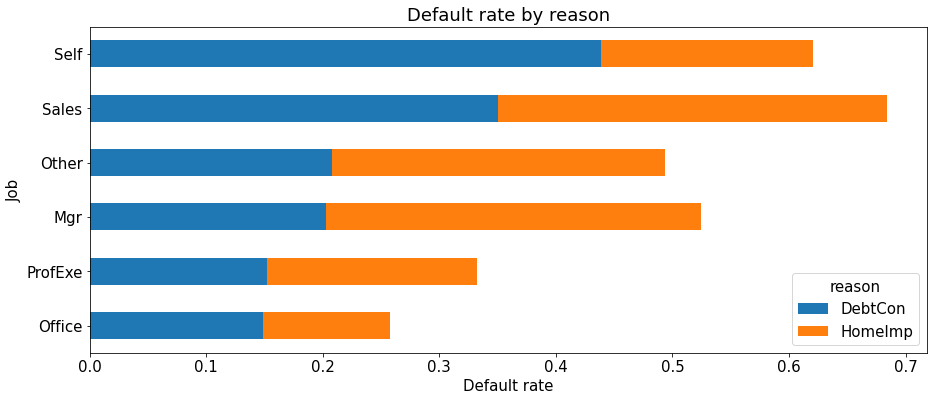

In [12]:
# pivot table and plot
pvt = df.pivot_table('bad', index = 'job', columns = 'reason', aggfunc = 'mean')
pvt.sort_values(by = ['DebtCon', 'HomeImp']).plot(kind = 'barh', stacked = True, figsize = (15,6))

plt.xlabel('Default rate')
plt.ylabel('Job')
plt.title('Default rate by reason')